In [23]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

from scipy.signal import convolve2d

import sys
from utils import *
test_utils()

Test utils ok


# Thème Image - TP5 - Détection de contours (suite et fin)

Ce TP est __noté__.
- Les travaux doivent être postés sur Chamilo (ou envoyés par mail à votre chargé de TP).
- Vous rendrez UN UNIQUE FICHIER au format `html` qui contiendra le compte rendu et les codes.
- Soyez attentifs à correctement commenter et indenter le code pour faciliter la lecture.
- **De manière générale, soyez attentifs à la présentation des résultats et à la 
  rédaction. Le thème de ce TP est l'image, il est donc obligatoire
  d'illustrer votre propos avec les images produites.**

<span style="color:red">**IMPORTANT**</span>

<span style="color:red">**Une fois tous les exercices terminés, vous exporterez le notebook au format HTML. Vous nommerez le fichier</span>

MAP201-\<Code du groupe\>-TP5-\<Prenom1\>-\<Nom1\>-\<Prenom2\>-\<Nom2\>,

<span style="color:red">**où vous remplacerez \<Code du groupe\> par le code de votre groupe de TP (e.g. INF-01) et \<Prenom\> et \<Nom\> par les prénoms et noms de votre binôme.**</span>

<span style="color:red">**C'est ce fichier (ou une conversion au format PDF) que vous devrez poster sur Chamilo (MAP201 / Groupes / Travaux) au plus tard le lendemain de votre séance de TP, à minuit.**
</span>


## Utilisation des filtres
A partir de maintenant vous utiliserez la routine `convolve2d(im, H)` de la bibliothèque `scipy.signal` pour 
appliquer un filtre `H` à une image `im`. Par rapport à la routine `moyenne2D_W` que vous avez programmée, 
`convolve2d` s'exécute plus rapidement.

Voir un exemple d'utilisation dans la cellule suivante. L'option `same` est importante pour que `im2` ait la même taille que `im1`.

L'utilisation des filtres gaussiens permet d'améliorer la qualité des contours dans de nombreux cas. Vous en aurez besoin par la suite. Il suffira d'appeler la fonction `W_gauss_2` (contenue dans `utils.py`).

Notez leur utilisation dans la cellule suivante et les résultats qu'ils produisent.

# Mise en évidence du problème de détection de contours

L'opération de seuillage décrite plus haut impose de choisir un seuil sur la norme du gradient, au-delà duquel un pixel donné est interprété comme un contour. Mais les pics de la norme du gradient n'ont pas tous la même hauteur, et il faut choisir un seuil suffisamment faible pour capter tous les contours significatifs. De ce fait, l'épaisseur des contours n'est pas constante et la méthode peut aboutir à des résultats qui ne sont pas satisfaisants.
L'exercice suivant illustre ce problème.

## Exercice 1 (4 points)
On considère l'image `im` obtenue dans la cellule suivante:

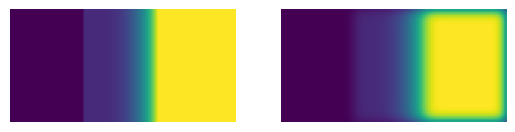

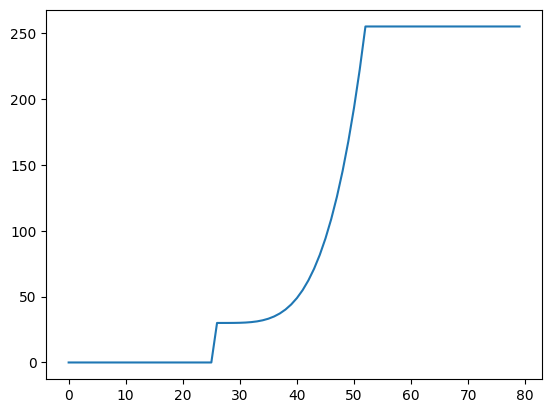

In [24]:
# image intialement noire
N = 40
M = 2*N
im = np.zeros([N,M])

# l'image est composée de trois bandes de taille n:
n = int(np.floor(M/3))

# le premier tiers reste noir

# le deuxième tiers est un dégradé avec un fort gradient
# de 30 à 255
for j in range(n,2*n):
    im[:,j] = 30 + 225 * ((j - n) / n) ** 4

# le dernier tiers est à 255
im[:,2*n:] = 255

# lissage gaussien 
G = W_gauss_2(2)
im2 = convolve2d(im, G, 'same')

fig,ax = plt.subplots(1,2)
ax[0].imshow(im);ax[0].set_axis_off()
ax[1].imshow(im2);ax[1].set_axis_off()

plt.figure();plt.plot(im[N//2,:])

Vous pouvez visualiser cette image avec la fonction `show_image`.

Comme vous pouvez le constater, cette image contient deux variations importantes aux colonnes `j = M/3` et `j = 2M/3` qu'on aimerait pouvoir identifier comme des contours.
- Essayez d'extraire les contours avec la fonction `contours_p`, en faisant varier le paramètre `p`. Que pensez-vous du résultat (sans se préoccuper des bords) ?
- Pouvez-vous trouver une valeur de `p` qui permette d'obtenir simultanément les contours en `M/3` et `2M/3` avec une épaisseur comparable ?
- Proposez une explication.
    *__Indication:__* visualiser la norme du gradient.


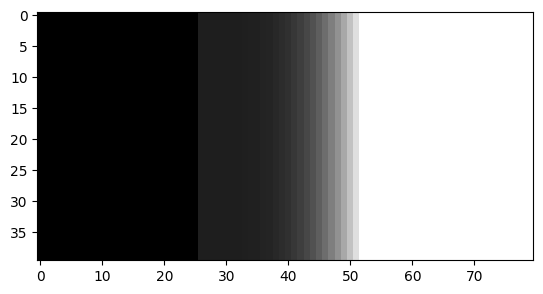

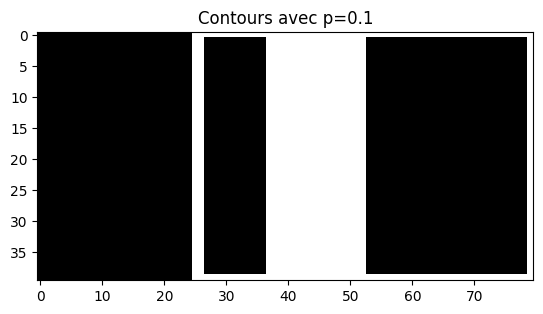

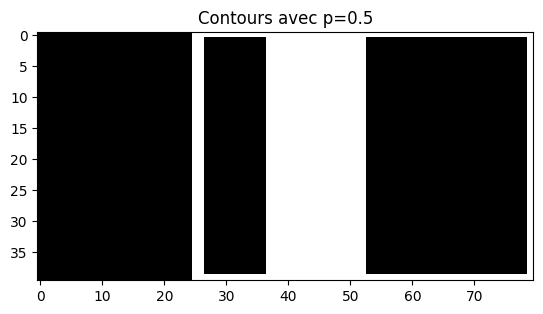

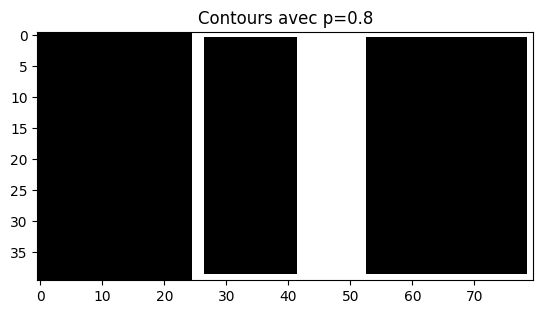

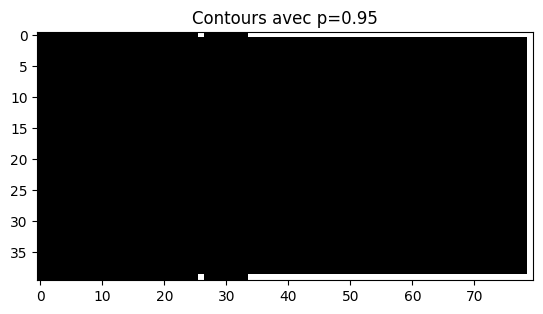

In [25]:
# A COMPLETER 
import matplotlib.pyplot as plt

# Chargez votre image
show_image(im)
# Essayez différentes valeurs de p
p_values = [0.1, 0.5, 0.8, 0.95]

for p in p_values:
    contours_result = contours_p(im, p)
    show_image(contours_result, title=f"Contours avec p={p}")
    plt.show()


# Elimination des non-maxima locaux

Avec la méthode précédente, on identifie trop de points en tant que contours.

Afin de pallier à ce problème on réexamine chaque pixel du contour  et on essaie d'identifier s'il correspond à un maximum de la norme du gradient dans la direction donnée par le vecteur gradient (qui est la direction de plus grande variation locale).
Ainsi, pour un pixel donné on compare sa valeur à celle de deux de ses voisins, choisis de manière à être les plus proches possibles de la direction du gradient. Il y a quatre cas possibles à choisir en fonction de la direction du gradient, comme illustré ci-dessous avec des exemples où le vecteur gradient est représenté par la flèche en pointillés.

![alt text](pixels.png "pixels")

Etant donnée une image `im`, on applique l'algorithme suivant :
- Soient `imx` et `imy` les tableaux contenant les dérivées partielles par rapport à $x$ et $y$, `imn` le tableau contenant la norme du gradient. On rappelle que ces trois tableaux ont la même taille que l'image `im`.

  Soit `imc` l'image des contours obtenue par seuillage de la norme du gradient 
- Pour chaque pixel `(u,v)` qui n'est pas sur le bord de l'image et tel que `imc(u,v) = 255` :
    - Calcul de l'angle $\phi$ du vecteur gradient $\tt (imx(u,v), imy(u,v))$ avec l'axe $x$, à l'aide de la fonction `np.atan` de `numpy` : `phi = np.atan(imy(u,v), imx(u,v))`. 
    - Si $\phi \leq 0$, on remplace $\phi$ par $\phi + \pi$, ce qui ne modifie pas la direction et permet de se ramener à une valeur dans l'intervalle $[0, \pi]$.
    - On détermine les pixels voisins qui sont les plus proches de la direction du gradient parmi les quatre cas illustrés ci-dessus en fonction de l'angle $\phi$ :

        - Si $\phi \leq \pi/8$ ou $\phi \geq 7\pi/8$ : cas 1.
        - Si $\pi/8 < \phi \leq 3\pi/8$ : cas 2.
        - Si $3\pi/8 < \phi < 5\pi/8$ : cas 3.
        - Si $5\pi/8 \leq \phi < 7\pi/8$ : cas 4.

![alt text](diagramme.png "pixels")


  - On compare la valeur de la norme du gradient dans le pixel central `(u,v)` à celles des deux voisins
    de l'étape précédente ; si une des deux valeurs est strictement supérieure, le pixel central n'est pas 
    un maximum local et on considère qu'il ne fait plus partie du contour : `imc(u,v) = 0`.

Les exercices suivants vous conduisent à implémenter cet algorithme.

## Exercice 2 (4 points)

**Identification des voisins les plus proches d'une direction donnée**.

Dans la cellule suivante, complétez la fonction `indices_voisins` pour qu'elle renvoie les indices `[u1,v1,u2,v2]` des pixels voisins du pixel `(u,v)` les plus proches de la direction donnée par l'angle `phi`. Cette fonction devra avoir le comportement suivant lorsque `(u,v)=(5,5)`:

`(u,v)=(5,5)` | `u1` | `v1` | `u2` | `v2` 
---|:---:|:---:|:---:|:---: 
 $ \phi = \pi / 16$ | `5` | `4` | `5` | `6`
$\phi = \pi / 4$| `6` | `4` | `4` | `6`
$\phi = \pi / 2$| `6` | `5` | `4` | `5`
$\phi = 3\pi / 4$|  `6` | `6` | `4` | `4`




In [26]:

def indices_voisins(phi, u, v):
    # Déterminer la direction en termes de changements d'indices
    if phi <= np.pi / 8 or phi >= 7 * np.pi / 8:
        # Cas 1
        u1=u
        v1=v-1
        u2=u
        v2=v+1
    elif np.pi / 8 < phi <= 3 * np.pi / 8:
        # Cas 2
        u1=u+1
        v1=v-1
        u2=u-1
        v2=v+1
        
    elif 3 * np.pi / 8 < phi < 5 * np.pi / 8:
        # Cas 3
        u1=u-1
        v1=v
        u2=u+1
        v2=v
    elif 5 * np.pi / 8 <= phi < 7 * np.pi / 8:
        # Cas 4
        u1=u-1
        v1=v-1
        u2=u+1
        v2=v+1

    return u1, v1, u2, v2



# Tests (vérifier avec le tableau ci-dessus)
indices_voisins(3*np.pi/4,5,5)


(4, 4, 6, 6)

## Exercice 3 (7 points)
**Mise en oeuvre de l'algorithme.**

- Ecrire une fonction `contours_max` qui :
  - prend en argument une image `im` et un pourcentage `p`,
  - calcule l'image des contours par seuillage,
  - applique l'algorithme détaillé plus haut pour éliminer les non maxima locaux,
  - puis renvoie l'image des contours.

(NB: vous aurez besoin de coder les fonctions `gradient`et `norme_gradient`).

- Vous pouvez la tester avec l'image de l'exercice 5. Vous devez obtenir comme contours deux traits verticaux d'épaisseur égale (en faisant abstraction des bords de l'image).

- Pour tester la bonne prise en compte des directions du gradient, vous pouvez la tester avec une image d'un disque obtenue avec la fonction `im = disque()` dans `utils`. Vous devez obtenir un cercle.

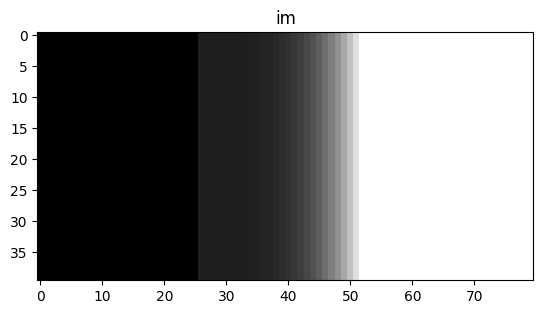

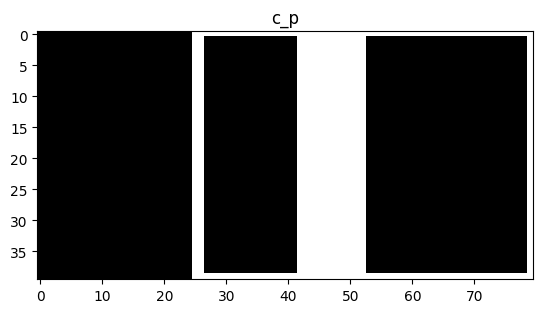

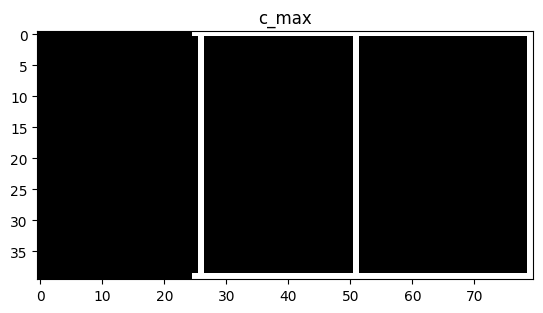

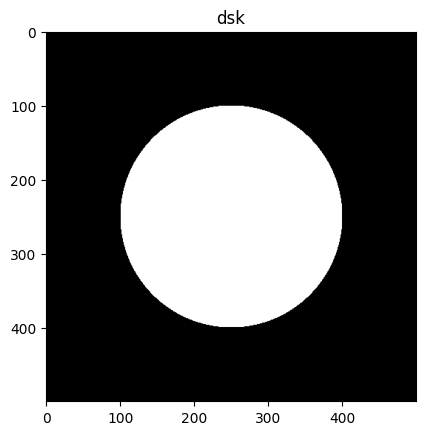

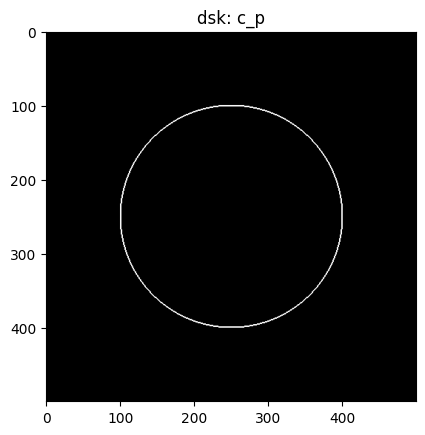

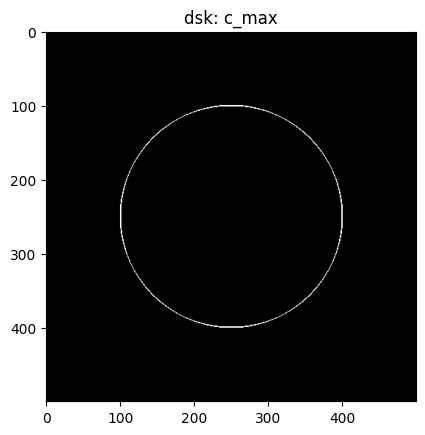

In [27]:

import numpy as np
from scipy.signal import convolve2d

def gradient(im):
    """
    Calcule le gradient de l'image im.
    
    Parameters:
    ===
    - im : image, tableau à deux dimensions.

    Returns:
    ===
    - Dx : Image de la dérivée partielle dans la direction x.
    - Dy : Image de la dérivée partielle dans la direction y.
    """
    # Filtres de Sobel pour les dérivées partielles dans les directions x et y
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    # Convolution avec les filtres de Sobel
    Dx = convolve2d(im, sobel_x, mode='same', boundary='symm')
    Dy = convolve2d(im, sobel_y, mode='same', boundary='symm')

    return Dx, Dy



def norme_gradient(im):
    """
    Fonction qui calcule la norme du gradient.
    In:
    ===
    - im : image.
    Out:
    ====
    - imn : image de la norme du gradient.
    """
    # A COMPLETER
    Dx, Dy=gradient(im)
    imn=np.sqrt(Dx**2 + Dy**2)
    return imn


def contours_max(im,p):
    ### A COMPLETER - DEBUT ###
    """
    Fonction qui calcule une image des contours de l'image im par seuillage puis par reduction
    des non-maxima locaux.
    In:
    ===
    - im : image
    - p : Valeur de p pour le calcul du seuil

    Out:
    ====
    - imc : contours de l'images im par réduction des non maxima locaux.
    """
    imx,imy = gradient(im)
    imn = norme_gradient(im)
    imc = contours_p(im,p)
    N,M = imn.shape
    for u in range(1,N-1): # On evite les bords
        for v in range(1,M-1): # On evite les bords
            norme_grad = imn[u,v]
            phi = np.arctan2(imy[u, v], imx[u, v])
            if phi < 0:
                phi += np.pi
            u1,v1,u2,v2 = indices_voisins(phi,u,v)
            if imn[u1,v1] > norme_grad or imn[u2,v2] > norme_grad:
                imc[u,v] = 0
    return imc


p = 0.8
c_p = contours_p(im,p)
c_max = contours_max(im,p)

show_image(im, title='im')
show_image(c_p, title='c_p')
show_image(c_max, title='c_max')


p = 0.8
dsk = disque()
c_p = contours_p(dsk,p)
c_max = contours_max(dsk,p)

show_image(dsk, title='dsk')
show_image(c_p, title='dsk: c_p')
show_image(c_max, title='dsk: c_max')


# Bruit, lissage, et détection des contours

### Exercice 4 (5 points)
Reprenez les images de l'exercice 4 et les valeurs de `sigma` et `p` que vous aviez choisies, et testez l'effet de l'élimination des non maxima locaux en comparant avec les résultats précédents. Commentez.



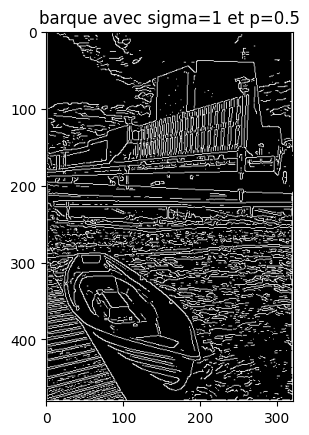

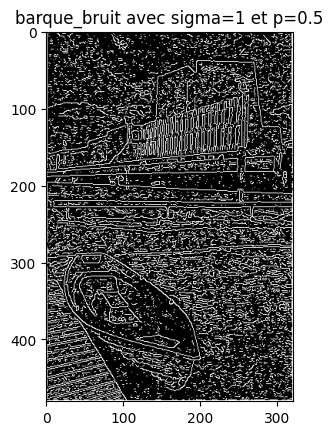

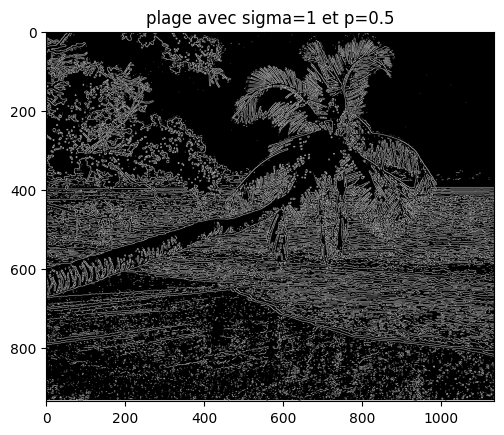

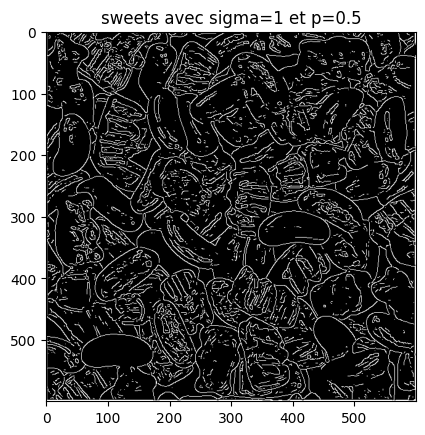

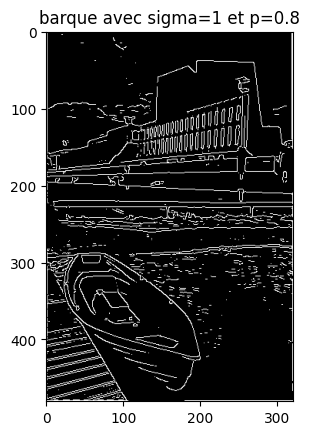

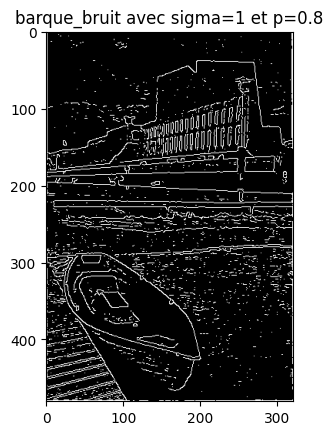

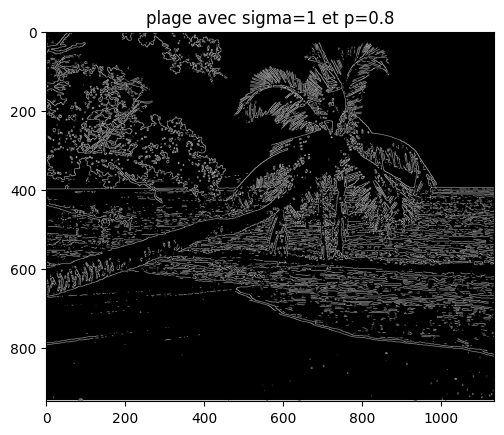

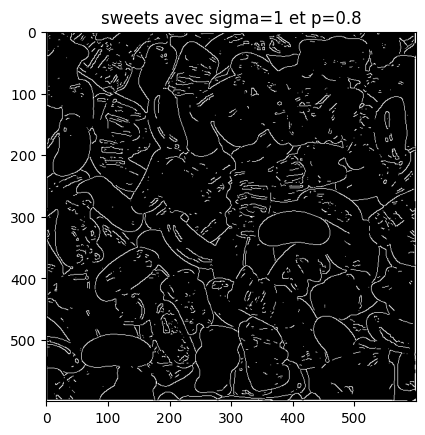

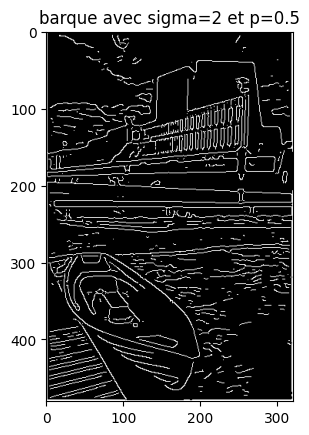

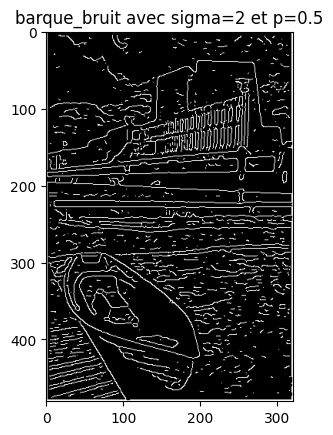

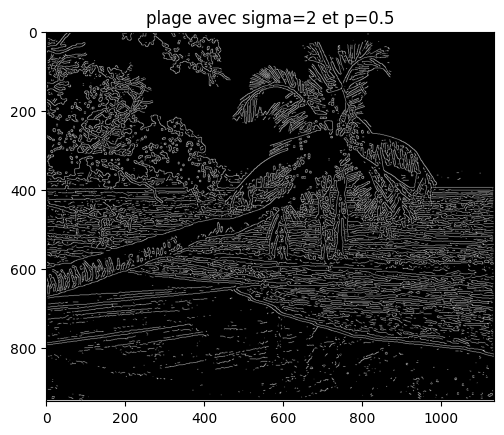

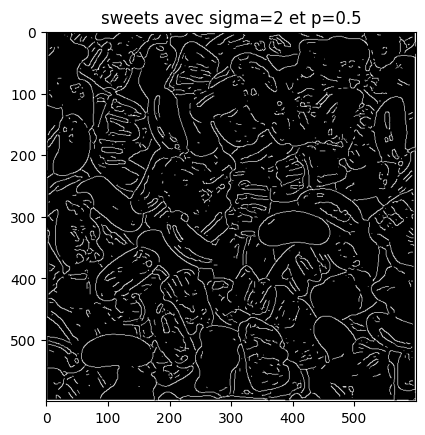

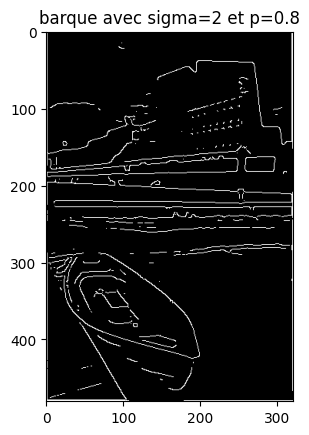

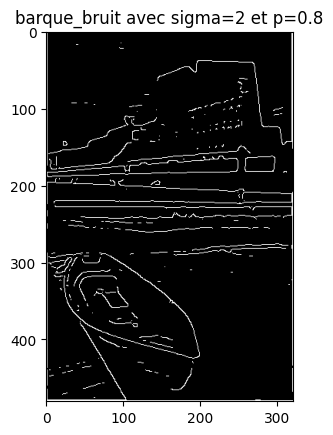

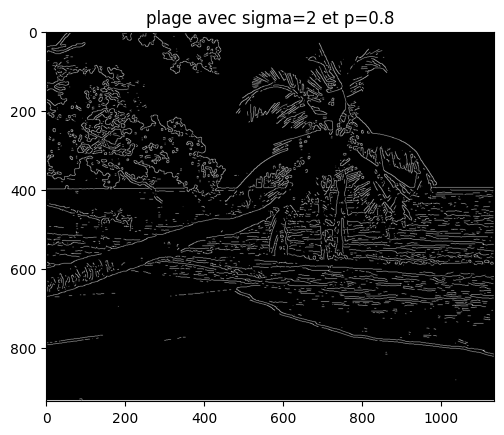

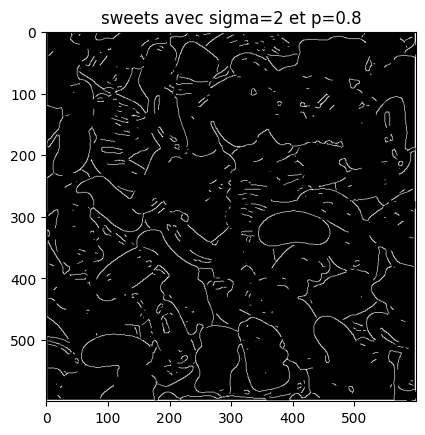

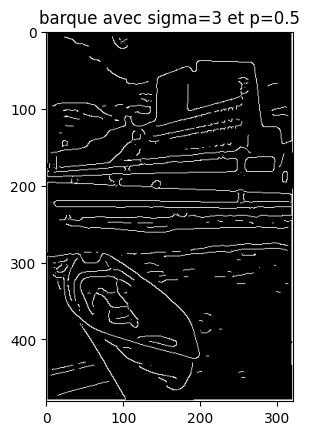

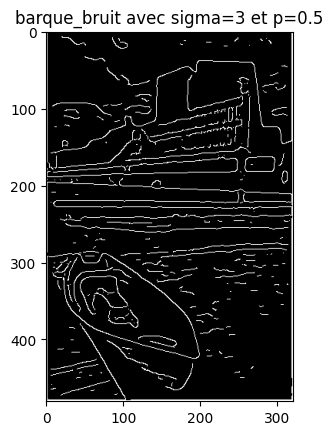

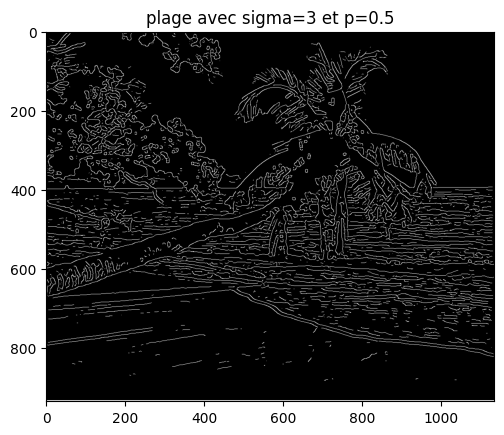

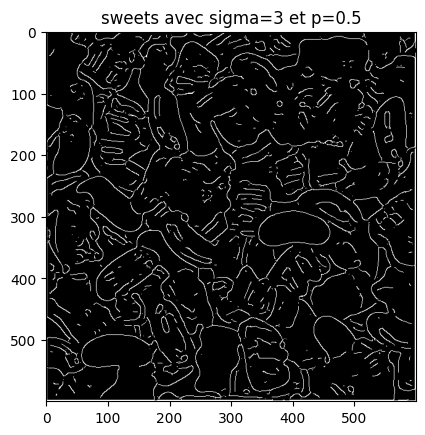

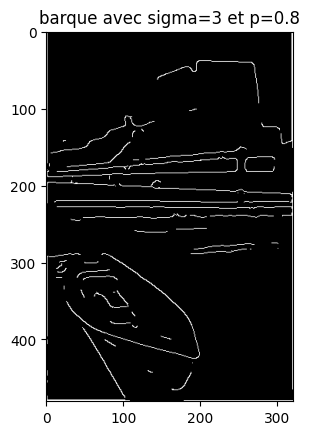

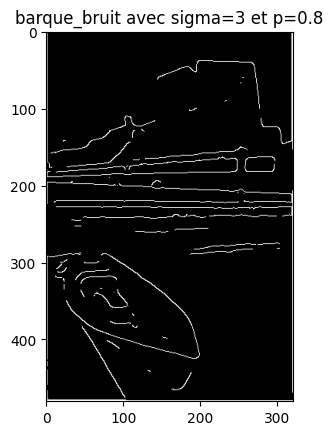

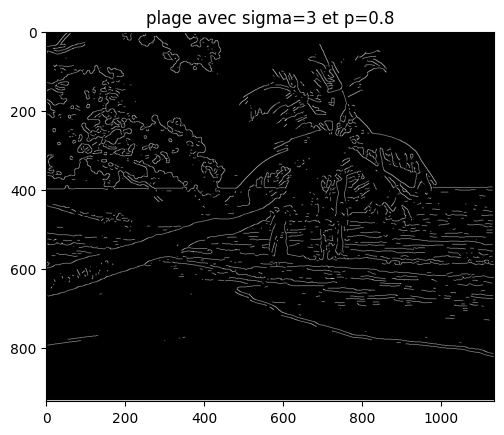

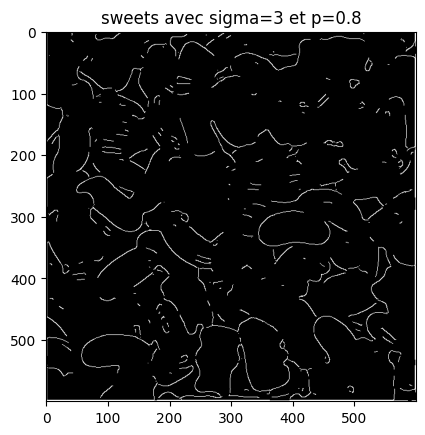

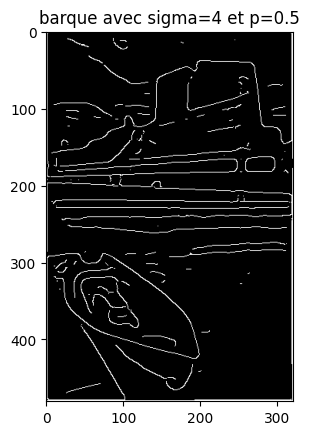

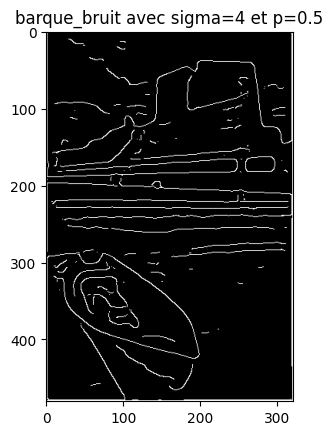

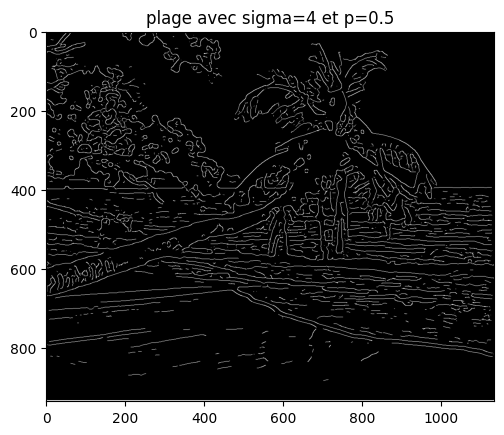

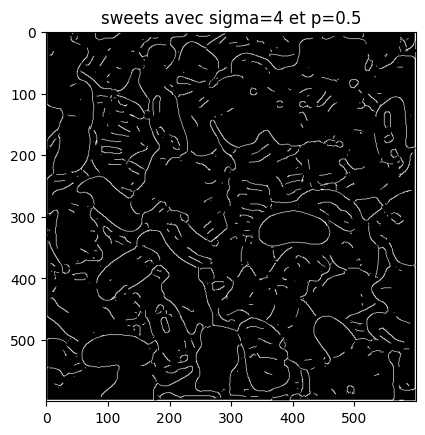

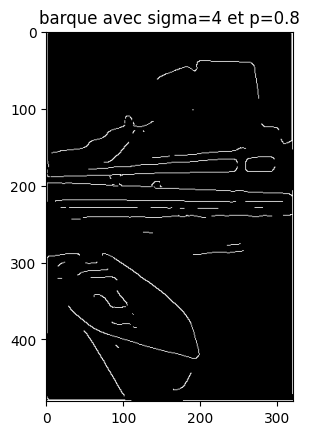

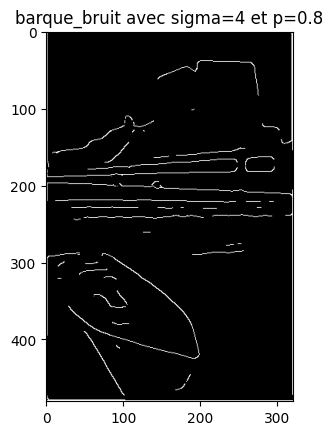

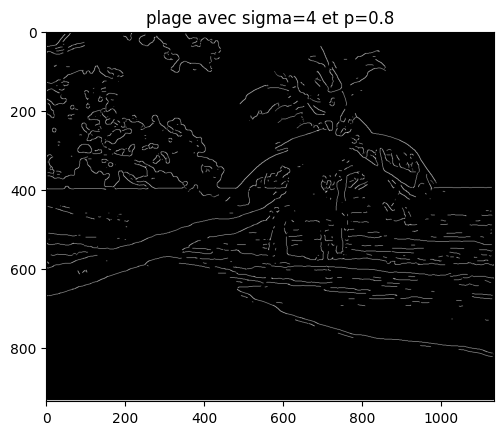

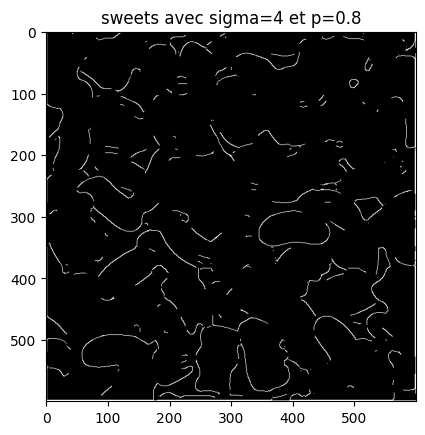

In [28]:
# A COMPLETER
# Importation des bibliothèques nécessaires
import matplotlib.pyplot as plt

# Définition des valeurs de sigma et p à tester
sigma_values = [1, 2, 3, 4]
p_values = [0.5, 0.8]

# Chargement des images
barque = plt.imread('barque.bmp')
barqueb = plt.imread('barque_bruit.bmp')
plage = plt.imread('plage.bmp')
sweets = plt.imread('sweets.bmp')

# Boucle pour tester différentes valeurs de sigma et p pour chaque image
for sigma in sigma_values:
    for p in p_values:
        # Application du filtre gaussien et détection de contours pour l'image 'barque'
        result = contours_max(convolve2d(barque, W_gauss_2(sigma), "same"), p)
        show_image(result, title=f"barque avec sigma={sigma} et p={p}")

        # Application du filtre gaussien et détection de contours pour l'image 'barque_bruit'
        result = contours_max(convolve2d(barqueb, W_gauss_2(sigma), "same"), p)
        show_image(result, title=f"barque_bruit avec sigma={sigma} et p={p}")

        # Application du filtre gaussien et détection de contours pour l'image 'plage'
        result = contours_max(convolve2d(plage, W_gauss_2(sigma), "same"), p)
        show_image(result, title=f"plage avec sigma={sigma} et p={p}")

        # Application du filtre gaussien et détection de contours pour l'image 'sweets'
        result = contours_max(convolve2d(sweets, W_gauss_2(sigma), "same"), p)
        show_image(result, title=f"sweets avec sigma={sigma} et p={p}")

### Exercice (Bonus)
Appliquer le masque flou vu dans le dernier exercice du TP3 avant d'appliquer votre méthode de détection de contours. Que constatez vous?

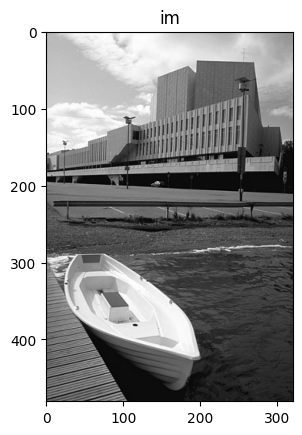

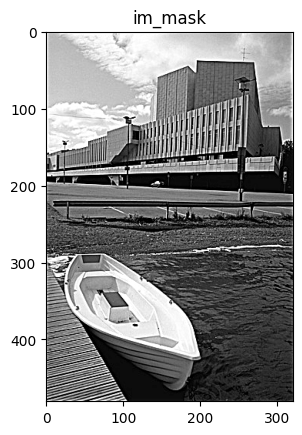

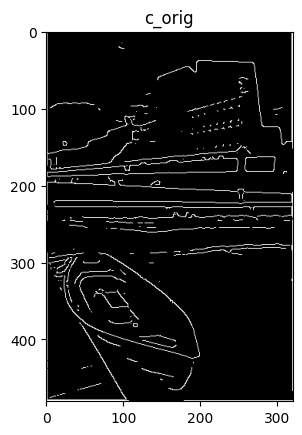

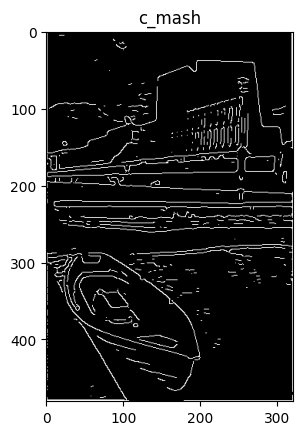

In [41]:

im = plt.imread('barque.bmp')
filtre = W_gauss_2(2)
imf = convolve2d(im,filtre,'same')

p=0.8
alpha = 2
masque_flou = im - imf
im_mask = np.clip(im + alpha * masque_flou, 0, 255)
show_image(im, title='im')
show_image(im_mask, title='im_mask')

c_orig = contours_max(convolve2d(im, W_gauss_2(alpha), "same"), p)
c_mask = contours_max(convolve2d(im_mask, W_gauss_2(alpha), "same"), p)

show_image(c_orig, title='c_orig')
show_image(c_mask, title='c_mash')

"""
En appliquant le masque flou avant la détection de contours, on obtiend probablement
 des contours moins nets, car le masque flou adoucit l'image avant l'application de la détection de contours.
 Cela peut être utile dans certaines applications pour réduire le bruit ou atténuer les contours trop prononcés."""


In [ ]:
""" 
****** COMPARATIF CONTOURS_P CONTOURS_MAX ******

La première méthode, contours_max, calcule les contours en utilisant la réduction des non-maxima 
locaux après avoir effectué un seuillage. Cette méthode essaie de supprimer les pixels non maximaux dans la direction du gradient.

La deuxième méthode, contours_p, utilise une approche différente pour déterminer le seuil en fonction d'un pourcentage p des pixels.
Elle utilise la fonction trouver_seuil pour identifier le seuil tel qu'un certain pourcentage des pixels ont une norme de gradient 
inférieure à ce seuil.

"""